# TPZ trees with protoDC2 data

By: Bela Abolfathi & Will Hartley

This notebook came out of work done during the 2018 LSST Sprint Week in Edinburgh. It goes through how to generate TPZ trees (http://matias-ck.com/mlz/tpz.html) using protoDC2 data to be used in the TXPipe framework. There are two different approaches to generate trees. The first trains a model using galaxies that have been randomly flagged for training ('training_flag' == True), while the second uses non-trivial training data that have a flat histogram in i-band magnitude, intended to give an example of 'bad' photo-z's. For more information on how this pessimissistic data set was generated, see this notebook by Sam Schmidt: https://github.com/LSSTDESC/pz_pdf/blob/u/sschmidt23/uniform_train/notebooks/protoDC2v5_uniform_training_selection.ipynb

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pandas as pd
import time

from mlz_desc.ml_codes import *

### Read in the data

All data: 18286706 galaxies, flat data: 107327 galaxies


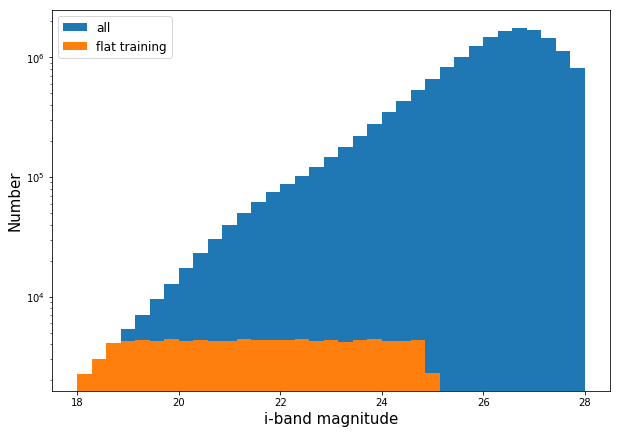

In [19]:
path = "/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC2/protoDC2v5"

## Full data set
all_file = "protodc2_v5_ugrizy_witherrs.h5"
all_path = os.path.join(path, all_file)
df = pd.read_hdf(all_path)


## Flat training data set
flat_file = "protodc2_v5_ugrizy_witherrs_flat_training.h5"
flat_path = os.path.join(path, flat_file)
flat_df = pd.read_hdf(flat_path)

## Plot distribution in i-band
print('All data: {} galaxies, flat data: {} galaxies'.format(len(df), len(flat_df)))
plt.figure(figsize=(10,7))
plt.hist(df['scatmag_i'], bins=35, range=(18,28), label='all')
plt.hist(flat_df['scatmag_i'], bins=35, range=(18,28), label='flat training')
plt.yscale('log')
plt.xlabel('i-band magnitude',fontsize=15)
plt.ylabel('Number',fontsize=15)
plt.legend(loc='upper left',fontsize=12)
plt.show()

#### Set the number trees and minimum leaf size based on what was used in Section 3.2.8 of the DC1 paper:

    In the present work, the LSST magnitudes u, g, r, i and colors u−g, g−r, r−i, i−z, z−y and their associated 
    errors are used in the process of growing 100 trees with a minimum leaf size of 5.

In [4]:
n_trees = 100
minleaf = 5

In [15]:
def prepare_df(df):
    
    '''This function makes a table that includes a subset of the 
    features in the given data set.'''
    
    input_df = pd.DataFrame()

    input_df['zs'] = df['redshift']
    input_df['u'] = df['scatmag_u']
    input_df['g'] = df['scatmag_g']
    input_df['r'] = df['scatmag_r']
    input_df['i'] = df['scatmag_i']

    u_g = df['scatmag_u'] - df['scatmag_g']
    g_r = df['scatmag_g'] - df['scatmag_r']
    r_i = df['scatmag_r'] - df['scatmag_i']
    i_z = df['scatmag_i'] - df['scatmag_z']
    z_y = df['scatmag_z'] - df['scatmag_y']

    input_df['u-g'] = u_g
    input_df['g-r'] = g_r
    input_df['r-i'] = r_i
    input_df['i-z'] = i_z
    input_df['z-y'] = z_y
    
    return(input_df)

#### Additional parameters used to run TPZ and save the output

In [6]:
save_path = "data/"

d = {'u': {'ind': 0}, 'g': {'ind': 1}, 'r': {'ind': 2}, 'i': {'ind': 3}, 'u-g': {'ind': 5}, 'g-r': {'ind': 6}, 
     'r-i': {'ind': 6}, 'i-z': {'ind': 6}, 'z-y': {'ind': 6}}

columns = ['mag_u_lsst','mag_g_lsst','mag_r_lsst','mag_i_lsst', 'mag_u_lsst-mag_g_lsst', 'mag_g_lsst-mag_r_lsst', 
            'mag_r_lsst-mag_i_lsst', 'mag_i_lsst-mag_z_lsst', 'mag_z_lsst-mag_y_lsst']

## Model 1: train on all data

In [17]:
## Select data flagged for training
training = df['training_flag'] == True
train_df = prepare_df(df[training])
## Separate features from labels
features, redshifts = train_df.loc[:,'u':'z-y'], train_df.loc[:,'zs']
print('Number of galaxies in training set: {}'.format(len(features.as_matrix()[::100])))

Number of galaxies in training set: 3899


In [8]:
## Create a forest from a set of decision trees and save
start_time = time.time()
Trees = [TPZ.Rtree(features.as_matrix()[::100], redshifts.as_matrix()[::100], minleaf=minleaf, mstar=3, dict_dim=d, 
                   forest='yes') for i in range(n_trees)]
print(time.time()-start_time)

532.5393090248108


In [10]:
save(os.path.join(save_path, 'protoDC2_trees_3899.npy'), [columns, Trees])

## Model 2: train on flat data

In [16]:
flat_train = flat_df['training_flag'] == True 
flat_train_df = prepare_df(flat_df[flat_train])
flat_features, flat_redshifts = flat_train_df.loc[:,'u':'z-y'], flat_train_df.loc[:,'zs']
print('Number of galaxies in training set: {}'.format(len(flat_features.as_matrix()[::3])))

Number of galaxies in training set: 3571


In [12]:
## Create a forest from a set of decision trees 
start_time = time.time()
Trees = [TPZ.Rtree(flat_features.as_matrix()[::3], flat_redshifts.as_matrix()[::3], minleaf=minleaf, mstar=3, dict_dim=d, 
                   forest='yes') for i in range(n_trees)]
print(time.time()-start_time)

456.0381100177765


In [13]:
save(os.path.join(save_path, 'protoDC2_flat_training_trees_3571.npy'), [columns, Trees])